In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


Using device: cpu


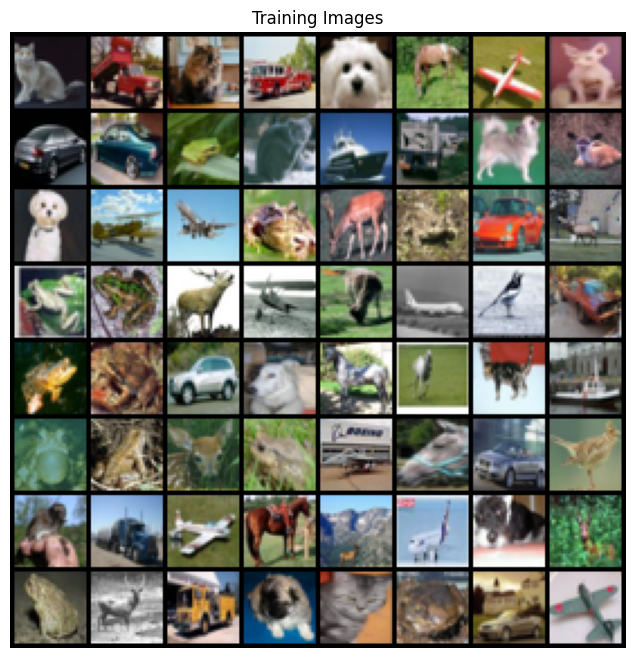

In [4]:
import torchvision
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np

# Configuration
dataroot = "/content/drive/MyDrive/Cifar-10/cifar10/cifar-10-batches-py"
image_size = 32  # CIFAR-10 is 32x32
batch_size = 128

# Create CIFAR-10 dataset for VAE
dataset = torchvision.datasets.CIFAR10(root=dataroot,
                                       train=True,
                                       download=True,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       ]))

# Create test dataset
test_dataset = torchvision.datasets.CIFAR10(root=dataroot,
                                            train=False,
                                            download=True,
                                            transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                            ]))

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

Using device: cpu
Starting VAE training...
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.314447
Train Epoch: 1 [1280/50000 (3%)]	Loss: 0.273023
Train Epoch: 1 [2560/50000 (5%)]	Loss: 0.273187
Train Epoch: 1 [3840/50000 (8%)]	Loss: 0.249695
Train Epoch: 1 [5120/50000 (10%)]	Loss: 0.252537
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.258863
Train Epoch: 1 [7680/50000 (15%)]	Loss: 0.281062
Train Epoch: 1 [8960/50000 (18%)]	Loss: 0.253944
Train Epoch: 1 [10240/50000 (20%)]	Loss: 0.271560
Train Epoch: 1 [11520/50000 (23%)]	Loss: 0.243191
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.247655
Train Epoch: 1 [14080/50000 (28%)]	Loss: 0.230357
Train Epoch: 1 [15360/50000 (31%)]	Loss: 0.244904
Train Epoch: 1 [16640/50000 (33%)]	Loss: 0.254398
Train Epoch: 1 [17920/50000 (36%)]	Loss: 0.254917
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.236643
Train Epoch: 1 [20480/50000 (41%)]	Loss: 0.221794
Train Epoch: 1 [21760/50000 (43%)]	Loss: 0.218674
Train Epoch: 1 [23040/50000 (46%)]	Loss: 0.252344
Train Epoch: 1 [24320/

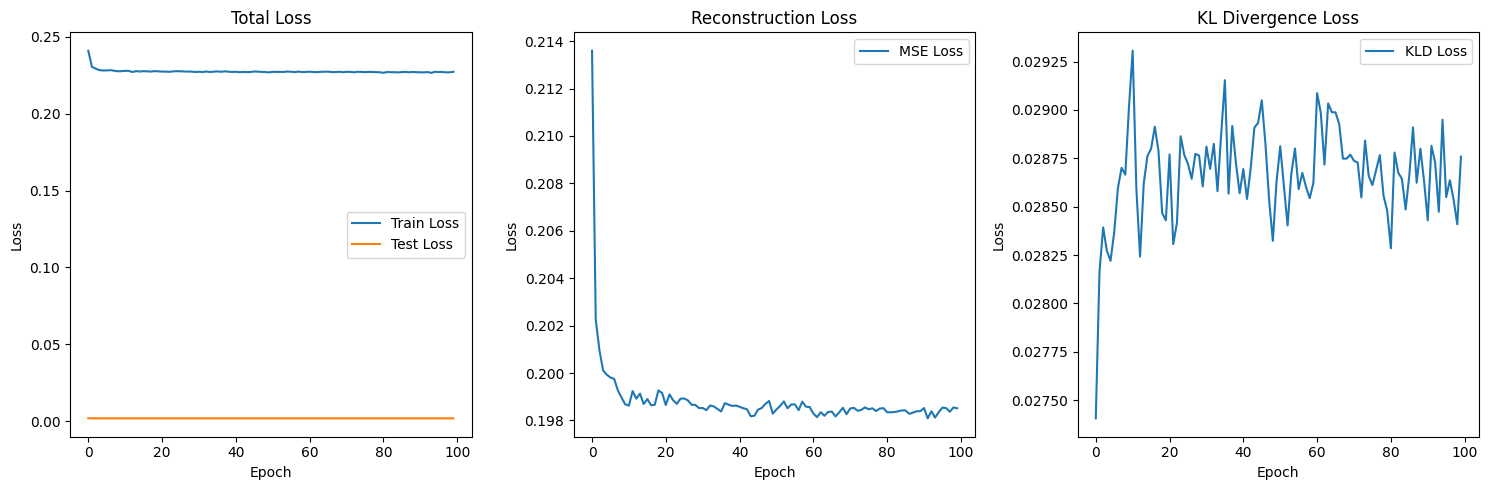


Final Results:
Final train loss: 0.2273
Final test loss: 0.0018
Final MSE: 0.1985
Final KLD: 0.0288


In [10]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# Configuration
batch_size = 128
epochs = 100
learning_rate = 1e-3
latent_dim = 20
log_interval = 10

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




class VAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu layer
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar layer

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3072))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss = Reconstruction loss + KL divergence"""
    MSE = F.mse_loss(recon_x, x.view(-1, 32*32*3), reduction='mean')


    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KL divergence averaged per sample
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


    return MSE + beta * KLD, MSE, KLD

def save_checkpoint(model, optimizer, epoch, train_loss, test_loss, path):
    """Save model and optimizer state along with epoch and losses."""
    checkpoint = {
        'epoch': epoch,
        'model': model,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_loss': test_loss
    }
    torch.save(checkpoint, path)
    print(f"✅ Checkpoint saved at {path}")

def train_epoch(model, train_loader, optimizer, epoch, device, beta=1.0):
    model.train()
    train_loss = 0
    train_MSE = 0
    train_kld = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, MSE, kld = loss_function(recon_batch, data, mu, logvar, beta)

        loss.backward()

        train_loss += loss.item()
        train_MSE += MSE.item()
        train_kld += kld.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.6f}')

    avg_loss = train_loss / len(train_loader)
    avg_MSE = train_MSE / len(train_loader)
    avg_kld = train_kld / len(train_loader)

    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f} '
          f'(MSE: {avg_MSE:.4f}, KLD: {avg_kld:.4f})')

    return avg_loss, avg_MSE, avg_kld


def test_epoch(model, test_loader, device, epoch, beta=1.0):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, _, _ = loss_function(recon_batch, data, mu, logvar, beta)
            test_loss += loss.item()

            # Save reconstruction comparison for first batch
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 32, 32)[:n]])
                save_image(comparison.cpu(),
                         f'/content/drive/MyDrive/VAE/samples_new/reconstruction_{epoch}.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    return test_loss


def generate_samples(model, device, epoch, num_samples=64):
    """Generate samples from random latent vectors"""
    model.eval()
    with torch.no_grad():
        sample = torch.randn(num_samples, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(num_samples, 3, 32, 32),
                   f'/content/drive/MyDrive/VAE/samples_new/sample_{epoch}.png')


# Initialize model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
test_losses = []
MSE_losses = []
kld_losses = []


print("Starting VAE training...")
for epoch in range(1, epochs + 1):
    # Train
    train_loss, train_MSE, train_kld = train_epoch(model, train_loader, optimizer, epoch, device)
    train_losses.append(train_loss)
    MSE_losses.append(train_MSE)
    kld_losses.append(train_kld)

    # Test
    test_loss = test_epoch(model, test_loader, device, epoch)
    test_losses.append(test_loss)

    # Generate samples
    generate_samples(model, device, epoch)
    ckpt_path = f"/content/drive/MyDrive/VAE/checkpoints_new/vae_epoch_{epoch}.pth"
    save_checkpoint(model, optimizer, epoch, train_loss, test_loss, ckpt_path)
print("Training completed!")

# Plot training progress
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(MSE_losses, label='MSE Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(kld_losses, label='KLD Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display final results
print(f"\nFinal Results:")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")
print(f"Final MSE: {MSE_losses[-1]:.4f}")
print(f"Final KLD: {kld_losses[-1]:.4f}")

Using device: cpu
Starting VAE training...
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.309155
Train Epoch: 1 [1280/50000 (3%)]	Loss: 0.312722
Train Epoch: 1 [2560/50000 (5%)]	Loss: 0.256369
Train Epoch: 1 [3840/50000 (8%)]	Loss: 0.244631
Train Epoch: 1 [5120/50000 (10%)]	Loss: 0.277009
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.231915
Train Epoch: 1 [7680/50000 (15%)]	Loss: 0.233600
Train Epoch: 1 [8960/50000 (18%)]	Loss: 0.256781
Train Epoch: 1 [10240/50000 (20%)]	Loss: 0.254889
Train Epoch: 1 [11520/50000 (23%)]	Loss: 0.242757
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.255275
Train Epoch: 1 [14080/50000 (28%)]	Loss: 0.252582
Train Epoch: 1 [15360/50000 (31%)]	Loss: 0.225301
Train Epoch: 1 [16640/50000 (33%)]	Loss: 0.239604
Train Epoch: 1 [17920/50000 (36%)]	Loss: 0.226786
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.230164
Train Epoch: 1 [20480/50000 (41%)]	Loss: 0.258987
Train Epoch: 1 [21760/50000 (43%)]	Loss: 0.238675
Train Epoch: 1 [23040/50000 (46%)]	Loss: 0.244260
Train Epoch: 1 [24320/

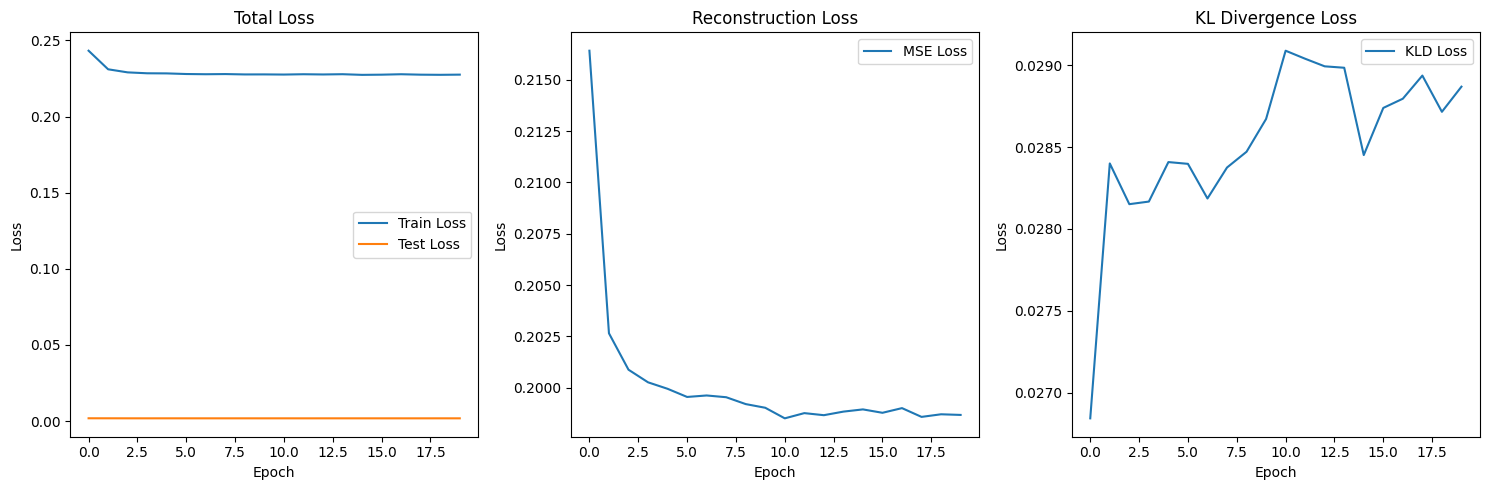


Final Results:
Final train loss: 0.2275
Final test loss: 0.0018
Final MSE: 0.1987
Final KLD: 0.0289


In [11]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

# Configuration
batch_size = 128
epochs = 20
learning_rate = 1e-3
latent_dim = 20
log_interval = 10

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




class VAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # mu layer
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # logvar layer

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 3072))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar, beta=4.0):
    """VAE loss = Reconstruction loss + KL divergence"""
    MSE = F.mse_loss(recon_x, x.view(-1, 32*32*3), reduction='mean')


    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KL divergence averaged per sample
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())


    return MSE + beta * KLD, MSE, KLD

def save_checkpoint(model, optimizer, epoch, train_loss, test_loss, path):
    """Save model and optimizer state along with epoch and losses."""
    checkpoint = {
        'epoch': epoch,
        'model': model,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_loss': test_loss
    }
    torch.save(checkpoint, path)
    print(f"✅ Checkpoint saved at {path}")

def train_epoch(model, train_loader, optimizer, epoch, device, beta=1.0):
    model.train()
    train_loss = 0
    train_MSE = 0
    train_kld = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss, MSE, kld = loss_function(recon_batch, data, mu, logvar, beta)

        loss.backward()

        train_loss += loss.item()
        train_MSE += MSE.item()
        train_kld += kld.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.6f}')

    avg_loss = train_loss / len(train_loader)
    avg_MSE = train_MSE / len(train_loader)
    avg_kld = train_kld / len(train_loader)

    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f} '
          f'(MSE: {avg_MSE:.4f}, KLD: {avg_kld:.4f})')

    return avg_loss, avg_MSE, avg_kld


def test_epoch(model, test_loader, device, epoch, beta=1.0):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, _, _ = loss_function(recon_batch, data, mu, logvar, beta)
            test_loss += loss.item()

            # Save reconstruction comparison for first batch
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 3, 32, 32)[:n]])
                save_image(comparison.cpu(),
                         f'/content/drive/MyDrive/VAE/checkpoint_beta_4/reconstruction_{epoch}.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    return test_loss


def generate_samples(model, device, epoch, num_samples=64):
    """Generate samples from random latent vectors"""
    model.eval()
    with torch.no_grad():
        sample = torch.randn(num_samples, latent_dim).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(num_samples, 3, 32, 32),
                   f'/content/drive/MyDrive/VAE/checkpoint_beta_4/sample_{epoch}.png')


# Initialize model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
test_losses = []
MSE_losses = []
kld_losses = []


print("Starting VAE training...")
for epoch in range(1, epochs + 1):
    # Train
    train_loss, train_MSE, train_kld = train_epoch(model, train_loader, optimizer, epoch, device)
    train_losses.append(train_loss)
    MSE_losses.append(train_MSE)
    kld_losses.append(train_kld)

    # Test
    test_loss = test_epoch(model, test_loader, device, epoch)
    test_losses.append(test_loss)

    # Generate samples
    generate_samples(model, device, epoch)
    ckpt_path = f"/content/drive/MyDrive/VAE/checkpoint_beta_4/vae_epoch_{epoch}.pth"
    save_checkpoint(model, optimizer, epoch, train_loss, test_loss, ckpt_path)
print("Training completed!")

# Plot training progress
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(MSE_losses, label='MSE Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(kld_losses, label='KLD Loss')
plt.title('KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display final results
print(f"\nFinal Results:")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")
print(f"Final MSE: {MSE_losses[-1]:.4f}")
print(f"Final KLD: {kld_losses[-1]:.4f}")